In [8]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from gensim.models import Word2Vec

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [27]:
raw_df = pd.read_csv('datasets/lyrics_by_year_1964_2023.csv', encoding='utf-8')
df = raw_df.sort_values(by=['year', 'id']).reset_index(drop=True)
df = df[~df['lyric'].isna()].drop('x_rated', axis=1)
df = df.drop_duplicates('id')
df

,id,year,title,singer,lyric
0,467355,1964,마도로스 부기,백야성,항구의 일번지 부기우기 일번지\n그라스를 채워다오 부기우기 아가씨\n고동이 슬피울면...
1,467498,1964,빨간구두 아가씨,남일해,솔솔솔 오솔길에 빨간구두 아가씨\n똑똑똑 구두소리 어딜 가시나\n한번쯤 뒤돌아 볼만...
2,992864,1964,아메리칸 마도로스,고봉산,무역선 오고가는 부산 항구 제2부두\n죄많은 마도로스 이별이 야속트라\n닷줄을 감으...
3,1002782,1964,동백아가씨,이미자,헤일 수 없이 수많은 밤을\n내 가슴 도려내는 아픔에 겨워\n얼마나 울었던가 동백아...
4,1003023,1964,눈물의 연평도,최숙자,조기를 담뿍잡아\n기폭을 올리고\n온다던 그배는\n어이하여 아니오나\n수평선 바라보...
...,...,...,...,...,...
4661,36635522,2023,ETA,NewJeans,낭비하지 마 네 시간은 은행\n서둘러서 정리해 걔는 real bad\n받아주면 안돼...
4662,36681074,2023,Fast Forward,전소미,I’m your future lover\n타락한 밤 너의 ruler\n영화 속 달콤...
4663,36713849,2023,Love Lee,AKMU 악뮤,You know\n내 스타일이 아닌 음악을 들어도\nYou know\n좋아하지 않는...
4664,36713850,2023,후라이의 꿈,AKMU 악뮤,저 거위도 벽을 넘어 하늘을 날을 거라고\n달팽이도 넓고 거친 바다 끝에 꿈을 둔다...


In [57]:
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

kiwi = Kiwi(num_workers=2)
stopwords_kr = Stopwords()

def token_str(token):
    return f"{token.form}|{token.tag}"

def get_words(t, filter_fn = lambda s: s) -> list:
    result = []
    for token in kiwi.tokenize(t, stopwords=stopwords_kr):
        if filter_fn(token):
            result.append(token_str(token))
    return result

In [60]:
token_str(kiwi.tokenize(df['lyric'].values[0])[0])

'항구|NNG'

In [32]:
corpus = []
for l in tqdm(df['lyric']):
    corpus.append(get_words(l))

# Word2Vec with skip-gram method
w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1000, workers=4, sg=1)

  0%|          | 0/4017 [00:00<?, ?it/s]

In [77]:
w2v.corpus_count

4017

In [31]:
dims = w2v.corpus_count
dims

4017

In [39]:
corpus[0]

'항구|NNG'

In [107]:
len(df), w2v.vector_size

(4017, 100)

In [106]:
lyrics_vectors = np.array([w2v.wv.get_mean_vector(c) for c in corpus])
lyrics_vectors.shape

(4017, 100)

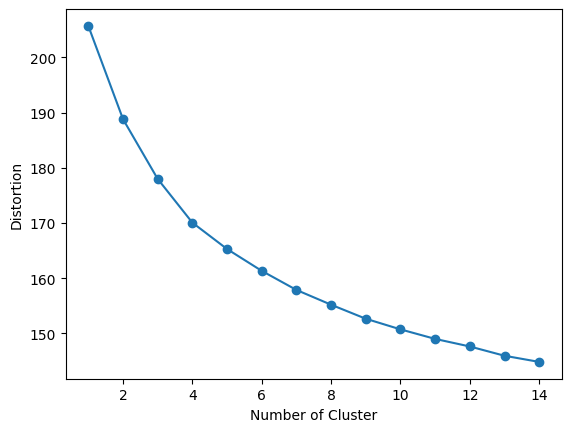

In [108]:
from sklearn.cluster import KMeans

def visualize_elbowmethod(data, n_clusters, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in n_clusters:
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=42)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.plot(n_clusters, distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

visualize_elbowmethod(lyrics_vectors, range(1, 15, 1), param_init='k-means++')

In [120]:
km = KMeans(init='k-means++', n_clusters=5, random_state=42)
km.fit(lyrics_vectors)
km.score(lyrics_vectors)

-165.4486846923828

In [121]:
df1 = df[['id', 'title', 'singer', 'lyric']].copy()
df1['cluster'] = km.predict(lyrics_vectors)
df1[['id', 'title', 'singer', 'lyric', 'cluster']].sort_values(by='cluster')

,id,title,singer,lyric,cluster
0,467355,마도로스 부기,백야성,항구의 일번지 부기우기 일번지\n그라스를 채워다오 부기우기 아가씨\n고동이 슬피울면...,0
3055,1724693,Tell me Sampling From 'Two Of Hearts',원더걸스,너도 날 좋아할 줄은 몰랐어\n어쩌면 좋아 너무나 좋아\n꿈만 같아서 나 내 자신을...,0
3057,1727552,매일매일,VOS,매일 매일 그댈 사랑해요\n내가 미안해요\n그런 말 하지 말아요\n음 음 음\n헤어...,0
3058,1730280,단발머리,이수영,오랜만이죠 조금 야위었네요\n짧은 머리도 어느새 길었네요\n우연히 보게 되니 살짝 ...,0
3059,1736294,못된 남자,엠투엠 M To M,이렇게 끝인가요 정말인가요\n왜 내게 잘해줬던 건가요\n그대는 착해서 난 못돼서\n...,0
...,...,...,...,...,...
3610,4095862,미스코리아,이효리,유리거울 속 저 예쁜 아가씨\n무슨 일 있나요 지쳐 보여요\n많은 이름에 힘이 드나...,4
3607,4085875,GENTLEMAN,싸이 PSY,알랑가몰라 왜 화끈해야\n하는건지\n알랑가몰라 왜 말끔해야\n하는건지\n알랑가몰라 ...,4
3605,4076109,외국인의 고백,AKMU 악뮤,당신은 Good이에요\n당신은 Great해요\n당신은 Amazing Marvello...,4
3585,4011608,I'm Sorry,CNBLUE 씨엔블루,It's over I'm sorry\nDo it do it do it now\nDo...,4


In [122]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100, random_state=42)
transformed = tsne.fit_transform(lyrics_vectors)
df1['stne_x'] = transformed[:, 0]
df1['stne_y'] = transformed[:, 1]
transformed.shape

(4017, 2)

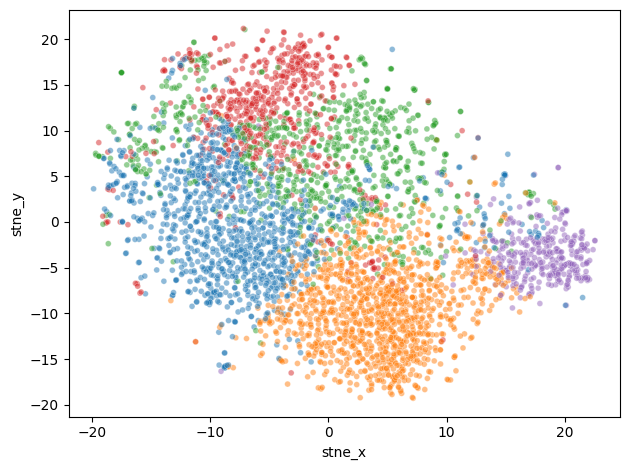

In [123]:
from matplotlib.patches import Rectangle

sns.scatterplot(data=df1, x='stne_x', y='stne_y', hue='cluster', size=2, legend=None, alpha=0.5, palette='tab10')
plt.gca().add_patch(Rectangle((-60, 0), 10, 10, fc="none", ec='g', lw=1))
plt.gca().add_patch(Rectangle((35, -20), 10, 10, fc="none", ec='r', lw=1))
plt.gca().add_patch(Rectangle((-15, -50), 10, 10, fc="none", ec='b', lw=1))
plt.tight_layout()
plt.show()

In [131]:
from wordcloud import WordCloud

fonts_dir = "notosanskr"
fonts = list(filter(lambda f: f.endswith(".otf"), os.listdir(fonts_dir)))
fonts = list(map(lambda f: os.path.join(fonts_dir, f), fonts))

In [137]:
def create_word_cloud(data: dict, max_font_size=128, width=512, height=512):
    wc = WordCloud(font_path=fonts[0], background_color="white", max_font_size=max_font_size, width=width, height=height)
    cloud = wc.generate_from_frequencies(data)
    return cloud


,id,title,singer,lyric,cluster,stne_x,stne_y
0,467355,마도로스 부기,백야성,항구의 일번지 부기우기 일번지\n그라스를 채워다오 부기우기 아가씨\n고동이 슬피울면...,0,-18.326494,5.590853
1,467498,빨간구두 아가씨,남일해,솔솔솔 오솔길에 빨간구두 아가씨\n똑똑똑 구두소리 어딜 가시나\n한번쯤 뒤돌아 볼만...,0,-14.740557,-2.896194
3,1002782,동백아가씨,이미자,헤일 수 없이 수많은 밤을\n내 가슴 도려내는 아픔에 겨워\n얼마나 울었던가 동백아...,0,-15.246856,0.920118
9,1324501,소쩍새 우는 마을,박재란,소쩍 소쩍새 울고간 뒤에 나풀나풀 나비가 춤추며 오네\n두꺼비도 잠 깨어 하품하는데...,0,-16.483557,5.999403
18,4083218,내일또 만납시다,금호동,하루의 일을 끝내고 돌아가는\n거리엔 사람의 물결\n하늘엔 별이 하나 둘 반짝이면\...,0,-6.533718,-0.175418
...,...,...,...,...,...,...,...
4614,35685439,자격지심 Feat ZICO,BE'O 비오,내 나이는 20\n하고도 플러스 2지\n주위 친구들은 일찍\n만들어 본인의 PPT\...,0,17.687712,-1.658001
4620,35890454,잘가요,주호,미안해 마요 이제야 난 깨달아요\n내 절대 그대 짝이 아님을\n괜찮을게요 영혼 밖에...,0,-10.514636,4.282951
4643,36382580,헤어지자 말해요,박재정,헤어지자고 말하려 오늘\n너에게 가다가 우리 추억 생각해 봤어\n처음 본 네 얼굴\...,0,-7.755805,8.055880
4654,36502910,모래 알갱이,임영웅,나는 작은 바람에도 흩어질\n나는 가벼운 모래 알갱이\n그대 이 모래에 작은 발걸음...,0,-11.498652,5.043401


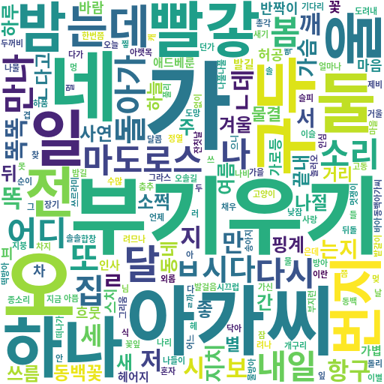

In [142]:
words = []
for l in df1[df1['cluster'] == 0]['lyric'].iloc[:5]:
    for token in kiwi.tokenize(l, stopwords=stopwords_kr):
        words.append(token.form)

create_word_cloud(Counter(words)).to_image().resize((384, 384))

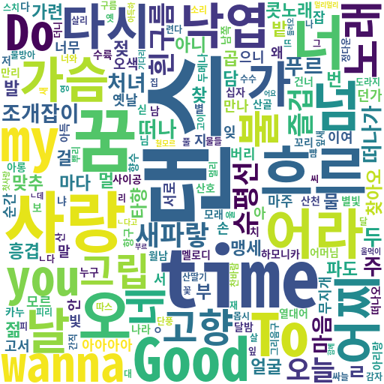

In [143]:
words = []
for l in df1[df1['cluster'] == 1]['lyric'].iloc[:5]:
    for token in kiwi.tokenize(l, stopwords=stopwords_kr):
        words.append(token.form)

create_word_cloud(Counter(words)).to_image().resize((384, 384))

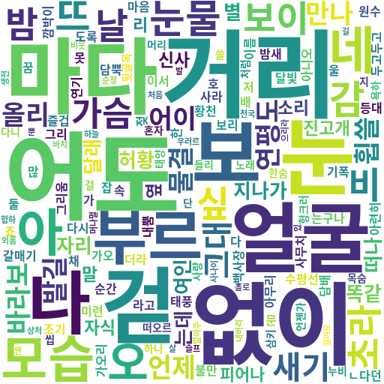

In [145]:
words = []
for l in df1[df1['cluster'] == 2]['lyric'].iloc[:5]:
    for token in kiwi.tokenize(l, stopwords=stopwords_kr):
        words.append(token.form)

create_word_cloud(Counter(words)).to_image().resize((384, 384))

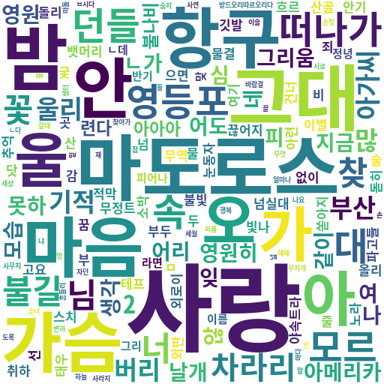

In [146]:
words = []
for l in df1[df1['cluster'] == 3]['lyric'].iloc[:5]:
    for token in kiwi.tokenize(l, stopwords=stopwords_kr):
        words.append(token.form)

create_word_cloud(Counter(words)).to_image().resize((384, 384))

In [154]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
This script require Homebrew!
Try https://brew.sh/


In [150]:
from konlpy.tag import Mecab
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument

In [164]:
mecab = Mecab()


['항구',
 '일',
 '번지',
 '부기우기',
 '일',
 '번지',
 '그라스',
 '채우',
 '달',
 '오',
 '부기우기',
 '아가씨',
 '고동',
 '슬피',
 '울',
 '이',
 '별',
 '란다']

In [185]:
tagged_corpus_list = []

for idx, row in tqdm(df1[['title', 'singer', 'lyric']].iterrows(), total=len(df1)):
    title = row['title']
    singer = row['singer']
    song = f"{title} - {singer}"
    lyric = row['lyric']
    # words = [
    #     token.form for token in kiwi.tokenize(lyric, stopwords=stopwords_kr)
    # ]
    # text = ' '.join(words)
    tagged_corpus_list.append(TaggedDocument(tags=[song], words=mecab.morphs(lyric)))

print(len(tagged_corpus_list))

  0%|          | 0/4017 [00:00<?, ?it/s]

4017


In [186]:
tagged_corpus_list[-1]

TaggedDocument(words=['Light', 'it', 'up', 'Light', 'it', 'up', 'Light', 'it', 'up', '나', '는', '달리', '거나', '넘어지', '거나', '둘', '중', '에', '하나', '야', '브레이크', '없', '는', 'bike', '택', '도', '없', '는', '것', '들', '을', '택', '도', '안', '뗀', '옷', '위', '로', 'stack', 'it', 'up', '난', '절대', '빠꾸', '없', '는', 'type', 'I', '’', 'm', 'gonna', 'smoke', 'you', 'up', 'I', '’', 'mma', 'smoke', 'you', 'I', '’', 'm', 'gonna', 'smoke', 'you', 'up', 'I', '’', 'mma', 'smoke', 'you', 'I', '’', 'm', 'gonna', 'smoke', 'you', 'up', 'I', '’', 'mma', 'smoke', 'you', '싹', '다', '부수', '고', '원상', '복구', '해', '(', 'light', 'it', 'up', ')', '적자생존', '아마', '난', '진짜', '1', '내일', '없', '는', '애', '들', '빈', '수레', '가', '요란', '해', 'that', '’', 's', 'why', 'I', '’', 'm', 'shooting', 'To', 'your', '골대', 'cuz', 'you', 'have', 'no', 'keeper', '차린', '것', '없', '는', '밥상', '들', '이', '밀', '지', '말', '고', 'zip', 'up', '저기', '빈털터리', '들', '재떨이', '에', '털', '어', '넣', '고', 'twerkin', '‘', 'Then', 'I', '’', 'mma', 'smoke', 'another', 'chance', 'You', 'kno

In [187]:
d2v = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, workers=8, window=8)
d2v

In [188]:
d2v.build_vocab(tagged_corpus_list)
d2v.train(tagged_corpus_list, total_examples=d2v.corpus_count, epochs=50)

In [256]:
d2v.save('lyrics.d2v')

In [214]:
fonts

['notosanskr/NotoSansMonoCJKkr-Bold.otf',
 'notosanskr/NotoSansMonoCJKkr-Regular.otf',
 'notosanskr/NotoSansCJKkr-DemiLight.otf',
 'notosanskr/NotoSansCJKkr-Black.otf',
 'notosanskr/NotoSansCJKkr-Medium.otf',
 'notosanskr/NotoSansCJKkr-Light.otf',
 'notosanskr/NotoSansCJKkr-Thin.otf',
 'notosanskr/NotoSansCJKkr-Regular.otf',
 'notosanskr/NotoSansCJKkr-Bold.otf']

In [249]:
import matplotlib.font_manager as fm

for font in fonts:
    fm.fontManager.addfont(font)
    font_prop = fm.FontProperties(fname=font)
    print(font_prop.get_name(), font)

sns.set(font="Noto Sans CJK KR")

Noto Sans Mono CJK KR notosanskr/NotoSansMonoCJKkr-Bold.otf
Noto Sans Mono CJK KR notosanskr/NotoSansMonoCJKkr-Regular.otf
Noto Sans CJK KR notosanskr/NotoSansCJKkr-DemiLight.otf
Noto Sans CJK KR notosanskr/NotoSansCJKkr-Black.otf
Noto Sans CJK KR notosanskr/NotoSansCJKkr-Medium.otf
Noto Sans CJK KR notosanskr/NotoSansCJKkr-Light.otf
Noto Sans CJK KR notosanskr/NotoSansCJKkr-Thin.otf
Noto Sans CJK KR notosanskr/NotoSansCJKkr-Regular.otf
Noto Sans CJK KR notosanskr/NotoSansCJKkr-Bold.otf


In [250]:
def plot_most_similar_songs(title):
    sim = pd.DataFrame(d2v.dv.most_similar(title))
    sns.barplot(data=sim, x=1, y=0, fill=True, color='gray')
    plt.title(f"\"{title}\"과 유사한 곡")
    plt.tight_layout()
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

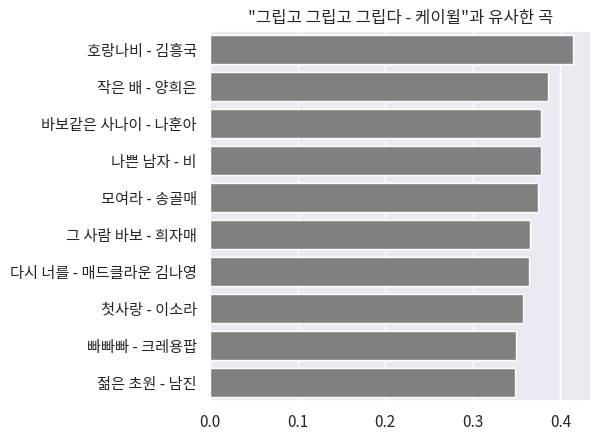

In [251]:
plot_most_similar_songs("그립고 그립고 그립다 - 케이윌")

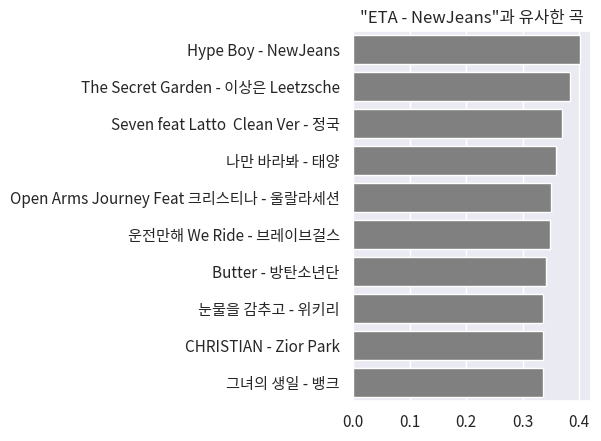

In [252]:
plot_most_similar_songs("ETA - NewJeans")

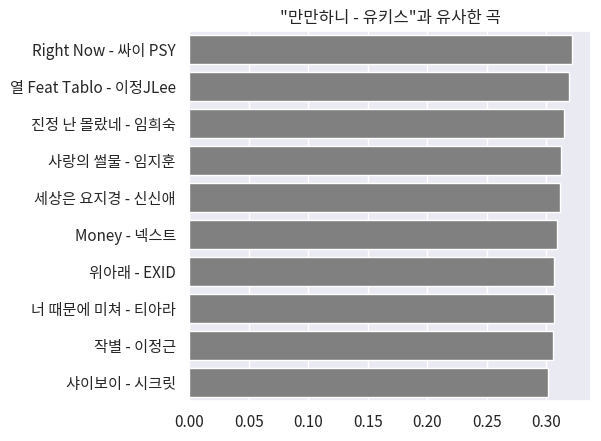

In [253]:
plot_most_similar_songs("만만하니 - 유키스")

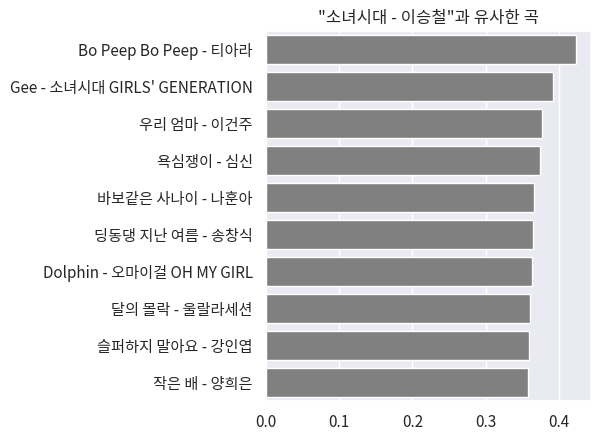

In [254]:
plot_most_similar_songs("소녀시대 - 이승철")

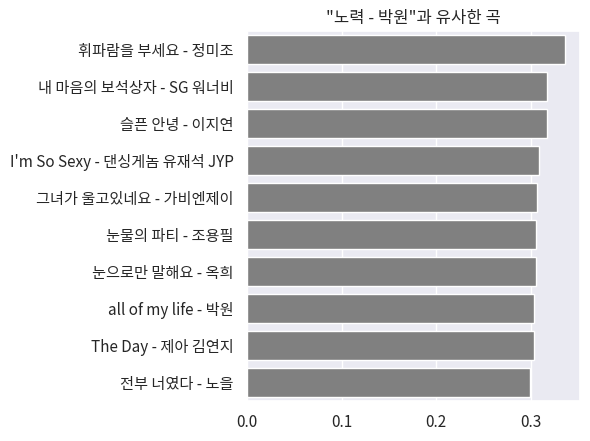

In [255]:
plot_most_similar_songs("노력 - 박원")

In [325]:
from gensim.corpora import Dictionary

In [380]:
tags = set(["NNG", "NNP", "NNB", "NP", "VV", "VA",])

def get_noun_only(lyric) -> list:
    corpus = []
    for line in lyric.split('\n'):
        tokens = kiwi.tokenize(line, stopwords=stopwords_kr)
        words = []
        for token in tokens:
            if token.tag in tags:
                words.append(token.form)
        if len(words) > 0:
            corpus.append(' '.join(words))
    return corpus

In [381]:
lyrics_all = []
for lyric in tqdm(df1['lyric']):
    lyrics_all.append(get_noun_only(lyric))

lyrics_all[:1]

  0%|          | 0/4017 [00:00<?, ?it/s]

[['항구 번지 부기우기 번지',
  '그라스 채우 부기우기 아가씨',
  '고동 울 이별',
  '달 지 전 이슬 깨 전',
  '부기우기 부기우기 마도로스 부기우기',
  '항구 번지 부기우기 번지',
  '인심 쓰 부기우기 아가씨',
  '오 가 마도로스',
  '달 지 전 정열 식 전',
  '부기우기 부기우기 마도로스 부기우기']]

In [382]:
import re
# lyrics_all = list(df1['lyric'].apply(lambda s: list(filter(lambda x: bool(re.sub('[0-9]', '', x).strip()), s.split('\n')))))
# lyrics_all = list(df1['lyric'].apply(get_noun_only))
common_dictionary = Dictionary(lyrics_all)
common_dictionary.filter_extremes(no_below=5)

In [383]:
common_dictionary.most_common(10)

[('사랑', 1854),
 ('너', 1500),
 ('그대', 602),
 ('너 사랑', 599),
 ('거', 473),
 ('잊', 419),
 ('알', 388),
 ('생각', 339),
 ('떠나', 326),
 ('모르', 322)]

In [384]:
common_corpus = [common_dictionary.doc2bow(text) for text in lyrics_all]
common_corpus

[[],
 [],
 [],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1)],
 [(5, 3), (6, 3), (7, 3)],
 [(8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1)],
 [(14, 1)],
 [(15, 1), (16, 1), (17, 1)],
 [(18, 2)],
 [],
 [(19, 1)],
 [(20, 2), (21, 2), (22, 2)],
 [],
 [(23, 1), (24, 1), (25, 2)],
 [],
 [],
 [],
 [(26, 3)],
 [],
 [],
 [(18, 1), (27, 1)],
 [(28, 1), (29, 2), (30, 1), (31, 2)],
 [],
 [(16, 1), (32, 1), (33, 1), (34, 1)],
 [],
 [(35, 2), (36, 4), (37, 2), (38, 1), (39, 2)],
 [(40, 2)],
 [],
 [],
 [(41, 1), (42, 1), (43, 2)],
 [],
 [],
 [],
 [(44, 4)],
 [(8, 1), (29, 1), (45, 1), (46, 1)],
 [(2, 1), (47, 2), (48, 2), (49, 2), (50, 2)],
 [],
 [(16, 1), (34, 2), (36, 1), (51, 1), (52, 2), (53, 1)],
 [(54, 1)],
 [],
 [],
 [(55, 1), (56, 1), (57, 1)],
 [(58, 1)],
 [(59, 2), (60, 1), (61, 2)],
 [],
 [(0, 2), (16, 1), (62, 2)],
 [(16, 2), (63, 2)],
 [(18, 1)],
 [(64, 1), (65, 1), (66, 1), (67, 3)],
 [(68, 4)],
 [(45, 2)],
 [(38, 2), (69, 1), (70, 2), (71, 1)],
 [(72, 1), (73, 1)],
 [],
 [(5, 1), (8

In [385]:
[[(common_dictionary[id], freq) for id, freq in cp] for cp in common_corpus[:5]]

[[], [], [], [('가슴 안', 1), ('날', 1), ('사연', 1), ('찾 오', 1)], [('이름 부르', 1)]]

In [510]:
from gensim.models import LdaModel, CoherenceModel

coherences_by_topics = []

for n_topics in range(2, 10+1):
    coh = []
    for seed in [42, 43, 44, 45, 46]:
        lda_tmp = LdaModel(common_corpus, id2word=common_dictionary, num_topics=n_topics, per_word_topics=True, chunksize=500, random_state=seed)
        coherence_model_lda = CoherenceModel(model=lda_tmp, texts=lyrics_all, dictionary=common_dictionary, coherence='c_v')
        coherence = coherence_model_lda.get_coherence()
        coh += [coherence]
        coherences_by_topics.append((n_topics, seed, coherence))
    coherence = np.array(coh).mean()
    print(f'Coherence Score with {n_topics} topics: ', coherence)

Coherence Score with 2 topics:  0.3694103445026614
Coherence Score with 3 topics:  0.3792292105898877
Coherence Score with 4 topics:  0.3762818028486673
Coherence Score with 5 topics:  0.3699143163382216
Coherence Score with 6 topics:  0.37922334767215793
Coherence Score with 7 topics:  0.37649012486217837
Coherence Score with 8 topics:  0.38776679901493016
Coherence Score with 9 topics:  0.39004465906469804
Coherence Score with 10 topics:  0.3891812900597755


In [511]:
coh_df = pd.DataFrame(coherences_by_topics, columns=['n_topics', 'random_seed', 'coherence'])
coh_df.sample(6).sort_values('n_topics')

,n_topics,random_seed,coherence
4,2,46,0.367437
14,4,46,0.418502
16,5,43,0.371768
24,6,46,0.389318
33,8,45,0.375517
41,10,43,0.384646


[]

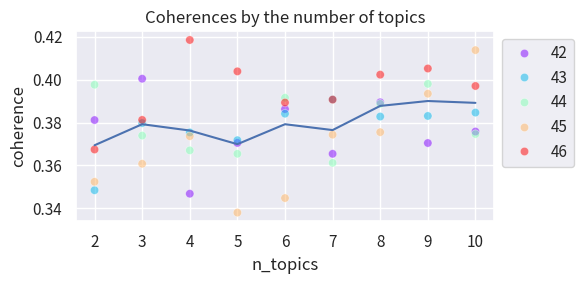

In [513]:
plt.figure(figsize=(6, 3))
sns.lineplot(data=coh_df.groupby('n_topics').mean(), x=coh_df['n_topics'].unique(), y='coherence')
sns.scatterplot(data=coh_df, x='n_topics', y='coherence', alpha=0.5, hue='random_seed', palette='rainbow')
plt.title('Coherences by the number of topics')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.plot()

In [514]:
lda = LdaModel(common_corpus,
               id2word=common_dictionary,
               num_topics=9,
               per_word_topics=True,
               chunksize=500,
               random_state=46)
lda

In [515]:
wp = lda.show_topic(0, topn=10)
", ".join([word for word, prop in wp])

'싫, 날, 사랑, 눈, 손, 사랑 주, 너 이름 부르, 너 어떻, 한마디, 슬프'

In [516]:
lda.print_topics()

[(0,
  '0.046*"싫" + 0.042*"날" + 0.037*"사랑" + 0.035*"눈" + 0.026*"손" + 0.025*"사랑 주" + 0.025*"너 이름 부르" + 0.024*"너 어떻" + 0.023*"한마디" + 0.023*"슬프"'),
 (1,
  '0.069*"순간" + 0.036*"안" + 0.035*"이렇" + 0.031*"사이" + 0.031*"이제" + 0.030*"모르" + 0.027*"다가오" + 0.022*"있" + 0.021*"영원" + 0.021*"거 주"'),
 (2,
  '0.058*"이름 부르" + 0.054*"재촉" + 0.045*"멈추" + 0.036*"흘러가" + 0.036*"잊" + 0.026*"미치" + 0.025*"시간 지나" + 0.023*"그날" + 0.022*"얼굴" + 0.021*"밤"'),
 (3,
  '0.086*"사랑" + 0.052*"알" + 0.045*"그대" + 0.036*"아프" + 0.035*"사랑 사랑 사랑" + 0.027*"미안" + 0.027*"사랑 거" + 0.022*"눈 감" + 0.021*"지내" + 0.021*"떠나가"'),
 (4,
  '0.250*"너" + 0.034*"만나 있" + 0.031*"알" + 0.027*"준비" + 0.022*"모르 척 지나가" + 0.018*"너 좋아하" + 0.016*"보이" + 0.015*"너 원하" + 0.015*"어쩌" + 0.013*"얘기"'),
 (5,
  '0.089*"너 사랑" + 0.046*"그렇" + 0.042*"대답" + 0.041*"번" + 0.030*"위" + 0.029*"바보" + 0.022*"만나" + 0.020*"떠나" + 0.020*"곁" + 0.020*"자신"'),
 (6,
  '0.084*"가" + 0.047*"세상 누구" + 0.045*"너 사랑 너 사랑" + 0.039*"행복" + 0.037*"지금" + 0.036*"세상" + 0.025*"돌아오 돌아오" + 0.024*"울" + 0.024*"너 부르

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)
with open('lda.html', mode='w', encoding='utf-8') as f:
    pyLDAvis.save_html(vis, f)

In [518]:
wp = lda.show_topic(1, topn=10)
print("|단어|중요도|\n|-|-|")
print("\n".join([f"|{word}|{prop:.5f}|" for word, prop in wp]))

|단어|중요도|
|-|-|
|순간|0.06931|
|안|0.03649|
|이렇|0.03513|
|사이|0.03065|
|이제|0.03055|
|모르|0.03042|
|다가오|0.02750|
|있|0.02157|
|영원|0.02100|
|거 주|0.02054|


In [520]:
import os
from openai import OpenAI

# OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
ai = OpenAI(api_key=OPENAI_API_KEY)

In [521]:
topic_count = lda.get_topics().shape[0]

topic_infos = []

for topic_id in tqdm(range(topic_count)):
    wp = lda.show_topic(topic_id, topn=10)
    keywords = [word for word, _ in wp]
    lda_qa_table = '\n'.join([
        "|단어|중요도|\n|-|-|",
        "\n".join([f"|{word}|{prop:.5f}|" for word, prop in wp])
    ])
    qa = "다음은 노래 가사로부터 추출한 단어와 그 중요도입니다. 어떤 주제인지 한 문장으로 표현하세요. 제약 사항을 준수하시오.\n"
    qa += f"{lda_qa_table}\n"
    qa += "제약 사항:\n" + '\n'.join([
        "- 음원 플레이리스트 제목처럼 작성하세요.",
        "- 최대한 간결하게 작성하세요.",
        "- 5단어 이상 사용하지 마세요",
    ])

    response = ai.chat.completions.create(
      model="gpt-3.5-turbo",
      response_format={ "type": "text" },
      messages=[
        {"role": "user", "content": qa},
      ]
    )
    ans = response.choices[0].message.content
    topic_infos.append((topic_id, keywords, ans))


topic_df = pd.DataFrame(topic_infos, columns=['topic_id', 'keywords', 'ai_desc'])
topic_df

  0%|          | 0/9 [00:00<?, ?it/s]

,topic_id,keywords,ai_desc
0,0,"[싫, 날, 사랑, 눈, 손, 사랑 주, 너 이름 부르, 너 어떻, 한마디, 슬프]",사랑과 슬픔을 담은 노래
1,1,"[순간, 안, 이렇, 사이, 이제, 모르, 다가오, 있, 영원, 거 주]",끝나지 않을 순간의 사이
2,2,"[이름 부르, 재촉, 멈추, 흘러가, 잊, 미치, 시간 지나, 그날, 얼굴, 밤]","끝없이 흘러가는 시간, 어느 밤에도 이름 부르며 잊지 않는 그날."
3,3,"[사랑, 알, 그대, 아프, 사랑 사랑 사랑, 미안, 사랑 거, 눈 감, 지내, 떠나가]",끝내기 힘든 사랑의 아픔
4,4,"[너, 만나 있, 알, 준비, 모르 척 지나가, 너 좋아하, 보이, 너 원하, 어쩌...",분리된 사랑의 감정과 관련된 단어들
5,5,"[너 사랑, 그렇, 대답, 번, 위, 바보, 만나, 떠나, 곁, 자신]",사랑과 이별의 고뇌
6,6,"[가, 세상 누구, 너 사랑 너 사랑, 행복, 지금, 세상, 돌아오 돌아오, 울, ...","너 사랑, 행복을 노래하는 시간"
7,7,"[사랑, 거, 누구, 괜찮, 사랑 사랑, 맘, 그대, 지금 곁, 이상, 좋]",사랑하는 사람과의 갈등과 어려움을 극복하는 이야기.
8,8,"[시간, 설레, 너 곁, 용기 내, 너 시간, 뭐, 맘 모르, 인사, 기다리, 약속]",너를 기다리는 설레임


In [522]:
topic_df.index = topic_df['topic_id']
topic_df = topic_df.drop('topic_id', axis=1)
topic_df

,keywords,ai_desc
topic_id,,
0,"[싫, 날, 사랑, 눈, 손, 사랑 주, 너 이름 부르, 너 어떻, 한마디, 슬프]",사랑과 슬픔을 담은 노래
1,"[순간, 안, 이렇, 사이, 이제, 모르, 다가오, 있, 영원, 거 주]",끝나지 않을 순간의 사이
2,"[이름 부르, 재촉, 멈추, 흘러가, 잊, 미치, 시간 지나, 그날, 얼굴, 밤]","끝없이 흘러가는 시간, 어느 밤에도 이름 부르며 잊지 않는 그날."
3,"[사랑, 알, 그대, 아프, 사랑 사랑 사랑, 미안, 사랑 거, 눈 감, 지내, 떠나가]",끝내기 힘든 사랑의 아픔
4,"[너, 만나 있, 알, 준비, 모르 척 지나가, 너 좋아하, 보이, 너 원하, 어쩌...",분리된 사랑의 감정과 관련된 단어들
5,"[너 사랑, 그렇, 대답, 번, 위, 바보, 만나, 떠나, 곁, 자신]",사랑과 이별의 고뇌
6,"[가, 세상 누구, 너 사랑 너 사랑, 행복, 지금, 세상, 돌아오 돌아오, 울, ...","너 사랑, 행복을 노래하는 시간"
7,"[사랑, 거, 누구, 괜찮, 사랑 사랑, 맘, 그대, 지금 곁, 이상, 좋]",사랑하는 사람과의 갈등과 어려움을 극복하는 이야기.
8,"[시간, 설레, 너 곁, 용기 내, 너 시간, 뭐, 맘 모르, 인사, 기다리, 약속]",너를 기다리는 설레임
